In [2]:
import keras
#from tensorflow.python.keras._impl.keras import __version__
keras.__version__ 

Using TensorFlow backend.


'2.2.4'

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [3]:
from keras.models import load_model
import os

base_dir = '/home/wangbin/1_Donkey_Analysis/'
model_path = os.path.join(base_dir,'models/tub_235_19-02-27.h5')


model = load_model(model_path)
model.summary()  # As a reminder.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 120, 160, 3)  0           img_in[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 160, 3)  12          cropping2d_1[0][0]               
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [4]:
img_path = os.path.join(base_dir,'data/tub_3_19-02-27/212_cam-image_array_.jpg')

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(120, 160))
img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis=0)

# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 120, 160, 3)


In [5]:
# from keras.applications.vgg16 import preprocess_input, decode_predictions

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
#x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
#x = preprocess_input(x)

In [6]:
preds = model.predict(img_tensor)
preds[0].shape
preds[0]
#print('Predicted:', decode_predictions(preds, top=3)[0])

array([[6.4599371e-05, 8.0268023e-09, 4.1200810e-08, 2.1899538e-08,
        1.4530267e-10, 5.2106791e-10, 1.3422931e-10, 8.7884434e-02,
        1.8133587e-08, 9.1128021e-09, 7.6085875e-09, 1.0355502e-09,
        1.0327197e-09, 6.2858014e-08, 9.1205078e-01]], dtype=float32)


The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [7]:
index = np.argmax(preds[0])

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [8]:
# This is the "line follow" entry in the prediction vector
linefollow_output = model.output[0][:, index]

In [9]:
from keras import backend as K

# The is the output feature map of the `conv2d_5` layer,
# the last convolutional layer in model
last_conv_layer = model.get_layer('conv2d_5')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(linefollow_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

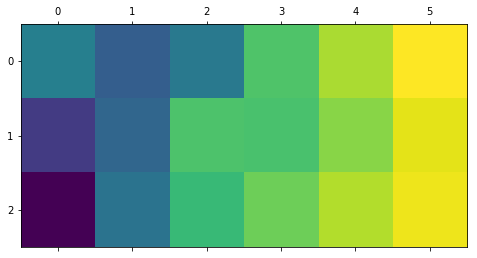

In [11]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap_raw = heatmap

heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [12]:
heatmap.shape

(3, 6)

In [13]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

cv2.imshow('img',img)
cv2.waitKey(0)

# We resize the heatmap to have the same size as the original image
heatmap_raw = cv2.resize(heatmap_raw, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap_raw = np.uint8(255 * heatmap_raw)

# We apply the heatmap to the original image
heatmap_raw = cv2.applyColorMap(heatmap_raw, cv2.COLORMAP_JET)

In [17]:
cv2.imshow('heatmap_raw',heatmap_raw)
cv2.waitKey(0)

heatmap_raw.shape

(120, 160, 3)

In [12]:

cv2.imshow('heatmap_raw',heatmap_raw)
cv2.waitKey(0)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap_raw * 0.4 + img

print(img_path)
output_img_path = img_path.split(r'/')[-1]
output_img_path = output_img_path.split('.')[0] + 'heatmap.jpg'
output_img_path = base_dir + '/heatmap/' + output_img_path

#cv2.imshow('superimposed_img',superimposed_img)
#cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the image to disk
cv2.imwrite(output_img_path, superimposed_img)

ValueError: operands could not be broadcast together with shapes (120,160) (120,160,3) 

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.
